### Mouse fetal gonads data (Niu et al., 2020) 

In [26]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '/home/jovyan/Prove/Gonads/Mouse_Niu_2020/figures/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

scanpy==1.4.6 anndata==0.7.1 umap==0.4.0 numpy==1.18.1 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


'/home/jovyan/my-conda-envs/celloracle_env/bin/python'

#### Import data
Import sample metadata from the paper

In [27]:
data_dir = '/nfs/team292/vl6/Mouse_Niu2020/'

# Create metadata 
import pandas as pd

meta = {
        'sample' : ['GSM4643732', 'GSM4643733', 'GSM4643734', 'GSM4643735', 'GSM4643736', 'GSM4643737',
                   'GSM4643738'],
        'stage' : ['E11.5', 'E12.5', 'E14.5', 'E16.5', 'E18.5', 'P1', 'P5'],
        'tissue' : ['gonad', 'ovary', 'ovary', 'ovary', 'ovary', 'ovary', 'ovary'],
        'farm_folder' : ['GSM4643732_E11.5gonad','GSM4643733_E12.5ovary', 'GSM4643734_E14.5ovary',
                        'GSM4643735_E16.5ovary', 'GSM4643736_E18.5ovary', 'GSM4643737_P1ovary', 
                        'GSM4643738_P5ovary']
        }

df = pd.DataFrame(meta, columns = ['sample', 'stage', 'tissue', 'farm_folder'])
df = df.set_index('farm_folder')
print('Number of samples: ', df.index.size)
df

Number of samples:  7


,sample,stage,tissue
farm_folder,,,
GSM4643732_E11.5gonad,GSM4643732,E11.5,gonad
GSM4643733_E12.5ovary,GSM4643733,E12.5,ovary
GSM4643734_E14.5ovary,GSM4643734,E14.5,ovary
GSM4643735_E16.5ovary,GSM4643735,E16.5,ovary
GSM4643736_E18.5ovary,GSM4643736,E18.5,ovary
GSM4643737_P1ovary,GSM4643737,P1,ovary
GSM4643738_P5ovary,GSM4643738,P5,ovary


#### Load table of gene orthologs between human and mouse 

 * Table was downloaded from **biomart** to include gene stable IDs (ENSEMBL IDs) and gene names for both human and mouse
 
 * Overall mapping of mouse gene names to human gene names is done by three intermediate mappings to ensure accuracy: 
 
     1. Mouse gene name to mouse ENSEMBL ID
     2. Mouse ENSEMBL ID to human ENSEMBL ID (very important that cross species mapping occurs at the level of ENSEMBL IDs as they are stable, unlike gene names)
     3. Human ENSEMBL ID to human gene name 

In [28]:
table = pd.read_csv('/nfs/team292/vl6/Mouse_Niu2020/biomart_human_mouse_orthologs.tsv',
                   sep = '\t')
print(table.shape)
print(table.columns.values)
table.head()

(23872, 4)
['Gene stable ID' 'Mouse gene stable ID' 'Mouse gene name' 'Gene name']


,Gene stable ID,Mouse gene stable ID,Mouse gene name,Gene name
0,ENSG00000198888,ENSMUSG00000064341,mt-Nd1,MT-ND1
1,ENSG00000198763,ENSMUSG00000064345,mt-Nd2,MT-ND2
2,ENSG00000198804,ENSMUSG00000064351,mt-Co1,MT-CO1
3,ENSG00000198712,ENSMUSG00000064354,mt-Co2,MT-CO2
4,ENSG00000228253,ENSMUSG00000064356,mt-Atp8,MT-ATP8


In [29]:
table = table.dropna()
table = table.drop_duplicates(['Gene stable ID'])
table = table.drop_duplicates(['Gene name'])
table = table.drop_duplicates(['Mouse gene stable ID'])
table = table.drop_duplicates(['Mouse gene name'])

table.shape

(17992, 4)

#### Preprocessing
**Load 10x**

Filter: 1) cells (< 10 genes); 2) genes (< 3 cells) 

Quantify: 1) % mitochondrial genes; 2) total counts

Convert mouse gene names to human orthologs as described above

In [30]:
holder = []
for sample in df.index:
    print(sample)
    # Load 10x data as AnnData
    adata = sc.read_10x_mtx(data_dir+sample,cache=True)
    adata.var_names_make_unique()
    holder.append(adata)
    # Set names of observation as sample + _ + barcode/probe 
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    # Filer cells with less than 10 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=150)
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    # add in metadata
    holder[-1].obs['sample'] = sample
    for val in df.columns:
        holder[-1].obs[val] = df[val][sample]
    # Extract mitochondial genes
    #convert to lower to be species agnostic: human mito start with MT-, mouse with mt-
    mito_genes = [name for name in holder[-1].var_names if name.lower().startswith('mt-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))
    
    # Convert mouse gene names to human orthologs
    table_copy = table # Create a copy otherwise the table gets modified at each iteration of the for loop
    var_names = holder[-1].var_names.to_list()
    table_copy = table_copy[table_copy['Mouse gene name'].isin(var_names)]
    table_copy = table_copy.set_index('Mouse gene name')
    gene_mapping_1 = table_copy['Mouse gene stable ID'].to_dict() # mouse gene name to mouse ENSEMBL
    tokeep1 = table_copy.index.to_list()
    holder[-1] = holder[-1][:, tokeep1]
    holder[-1].var['mouse_ENSEMBL'] = holder[-1].var.index.map(gene_mapping_1)
    
    gene_mapping_2 = pd.Series(table_copy['Gene stable ID'].values,index=table_copy['Mouse gene stable ID']).to_dict() # mouse ENSEMBL to human ENSEMBL
    holder[-1].var['human_ENSEMBL'] = holder[-1].var['mouse_ENSEMBL'].map(gene_mapping_2)
    
    gene_mapping_3 = pd.Series(table_copy['Gene name'].values,index=table_copy['Gene stable ID']).to_dict() # human ENSEMBL to human gene name
    holder[-1].var['human_gene_name'] = holder[-1].var['human_ENSEMBL'].map(gene_mapping_3)
    
    # Set human gene name as default var names 
    holder[-1].var['mouse_gene_name'] = holder[-1].var_names
    holder[-1].var_names = holder[-1].var['human_gene_name']
    holder[-1].var.rename(columns={'human_gene_name': 'human_gene_ortholog'}, inplace=True)


GSM4643732_E11.5gonad
... reading from cache file cache/nfs-team292-vl6-Mouse_Niu2020-GSM4643732_E11.5gonad-matrix.h5ad


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 28 cells that have less than 150 genes expressed


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 11726 genes that are detected in less than 3 cells


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.


Total number of cells: 8265
Total number of genes: 19327
GSM4643733_E12.5ovary
... reading from cache file cache/nfs-team292-vl6-Mouse_Niu2020-GSM4643733_E12.5ovary-matrix.h5ad
filtered out 32 cells that have less than 150 genes expressed
filtered out 11976 genes that are detected in less than 3 cells


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Total number of cells: 4712
Total number of genes: 19077


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.


GSM4643734_E14.5ovary
... reading from cache file cache/nfs-team292-vl6-Mouse_Niu2020-GSM4643734_E14.5ovary-matrix.h5ad
filtered out 267 cells that have less than 150 genes expressed


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 11590 genes that are detected in less than 3 cells


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.


Total number of cells: 11150
Total number of genes: 19463
GSM4643735_E16.5ovary
... reading from cache file cache/nfs-team292-vl6-Mouse_Niu2020-GSM4643735_E16.5ovary-matrix.h5ad
filtered out 133 cells that have less than 150 genes expressed


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 9354 genes that are detected in less than 3 cells


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.


Total number of cells: 10909
Total number of genes: 21699
GSM4643736_E18.5ovary
... reading from cache file cache/nfs-team292-vl6-Mouse_Niu2020-GSM4643736_E18.5ovary-matrix.h5ad
filtered out 247 cells that have less than 150 genes expressed
filtered out 12249 genes that are detected in less than 3 cells


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.


Total number of cells: 3871
Total number of genes: 18804
GSM4643737_P1ovary
... reading from cache file cache/nfs-team292-vl6-Mouse_Niu2020-GSM4643737_P1ovary-matrix.h5ad
filtered out 333 cells that have less than 150 genes expressed
filtered out 12071 genes that are detected in less than 3 cells


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Total number of cells: 6076
Total number of genes: 18982


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.


GSM4643738_P5ovary
... reading from cache file cache/nfs-team292-vl6-Mouse_Niu2020-GSM4643738_P5ovary-matrix.h5ad
filtered out 314 cells that have less than 150 genes expressed
filtered out 12077 genes that are detected in less than 3 cells


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Total number of cells: 6205
Total number of genes: 18976


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.


In [31]:
# confirm N samples
print(len(holder))
# merge datasets
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

7


AnnData object with n_obs × n_vars = 51188 × 15799 
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'stage', 'tissue'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'mouse_ENSEMBL-0', 'human_ENSEMBL-0', 'human_gene_ortholog-0', 'mouse_gene_name-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'mouse_ENSEMBL-1', 'human_ENSEMBL-1', 'human_gene_ortholog-1', 'mouse_gene_name-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'mouse_ENSEMBL-2', 'human_ENSEMBL-2', 'human_gene_ortholog-2', 'mouse_gene_name-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'mouse_ENSEMBL-3', 'human_ENSEMBL-3', 'human_gene_ortholog-3', 'mouse_gene_name-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'mouse_ENSEMBL-4', 'human_ENSEMBL-4', 'human_gene_ortholog-4', 'mouse_gene_name-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'mouse_ENSEMBL-5', 'human_ENSEMBL-5', 'human_gene_ortholog-5', 'mouse_gene_name-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'mouse_ENSEMBL-6', 'human_EN

### QC pplots

Plot distributions of the values n_genes, n_counts and percent_mito

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1154: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'tissue' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'mouse_ENSEMBL-0' as categorical
... storing 'human_ENSEMBL-0' as categorical
... storing 'human_gene_ortholog-0' as categorical
... storing 'mouse_gene_name-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'mouse_ENSEMBL-1' as categorical
... storing 'human_ENSEMBL-1' as categorical
... storing 'human_gene_ortholog-1' as categorical
... storing 'mouse_gene_name-1' as categorical
... storing 'gene_ids-2' as categorical
... storing 'feature_type

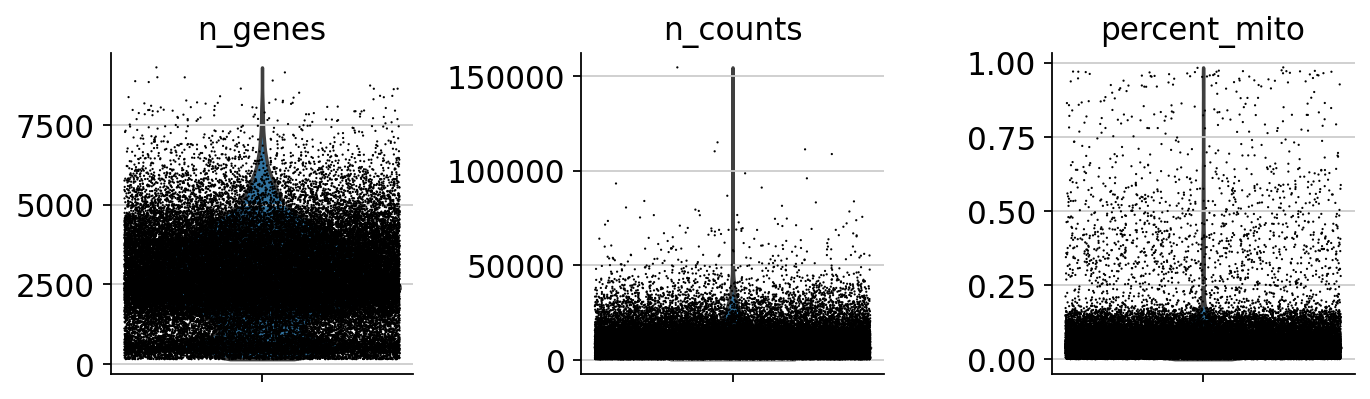

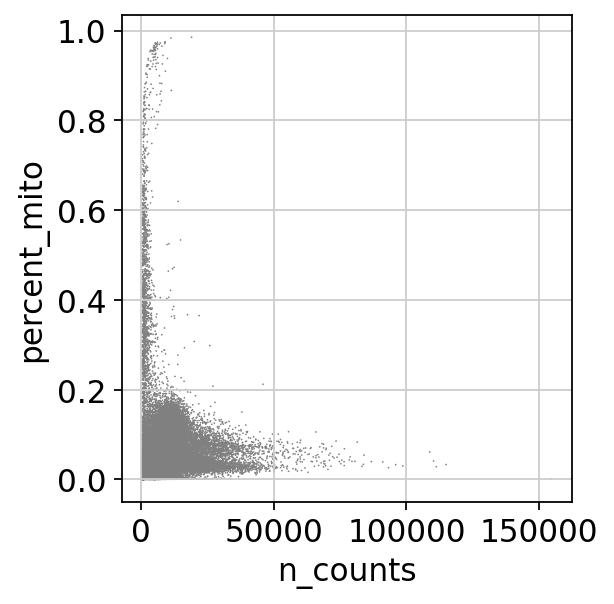

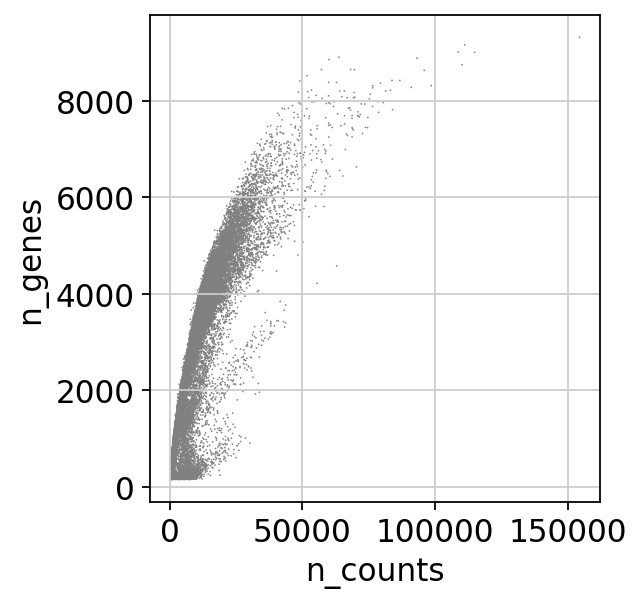

In [32]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf')
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf')
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf')

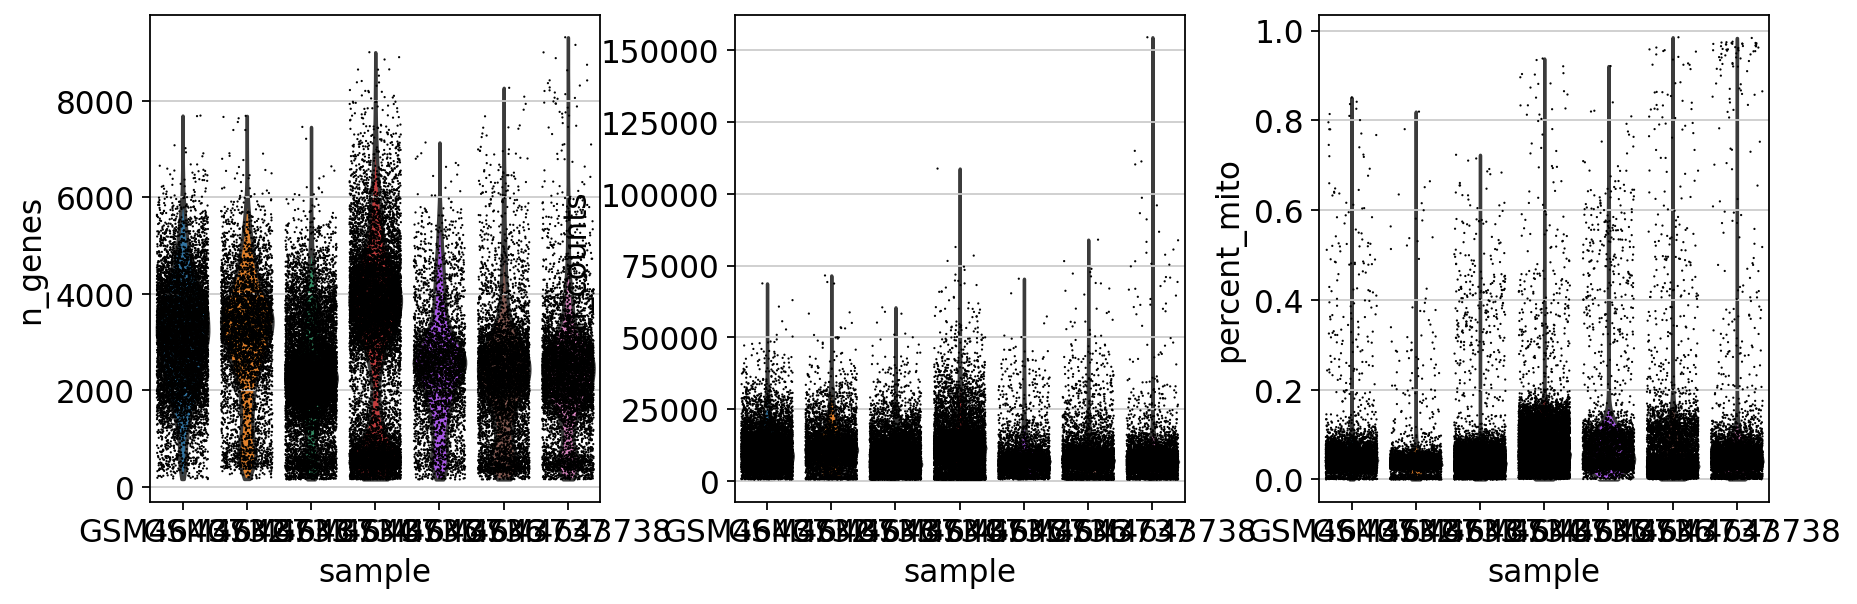

In [33]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='sample', jitter=0.4, wspace = 0.5, save='_perindividual.pdf')

In [34]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 51188
Total number of genes: 15799


### Filter cells with few genes
Check number of genes per cell distribution and filter cells accordingly

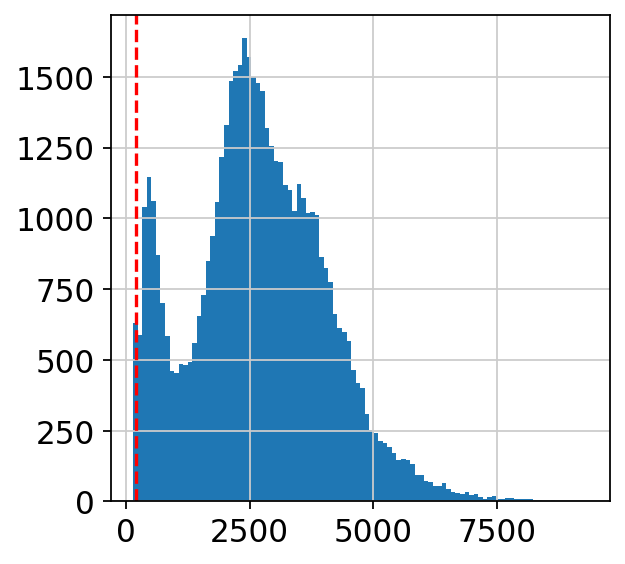

In [35]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(200, linestyle = '--', color = 'red')

In [36]:
sc.pp.filter_cells(adata, min_genes=200)

filtered out 579 cells that have less than 200 genes expressed


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [37]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['sample'].values.describe()

Total number of cells: 50609
Total number of genes: 15799


,counts,freqs
categories,,
GSM4643732,8248,0.162975
GSM4643733,4703,0.092928
GSM4643734,11013,0.217610
GSM4643735,10677,0.210970
GSM4643736,3836,0.075797
GSM4643737,6008,0.118714
GSM4643738,6124,0.121006


### Filter genes expressed in less than 3 cells

In [38]:
sc.pp.filter_genes(adata, min_cells=3)

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [39]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['sample'].values.describe()

Total number of cells: 50609
Total number of genes: 15799


,counts,freqs
categories,,
GSM4643732,8248,0.162975
GSM4643733,4703,0.092928
GSM4643734,11013,0.217610
GSM4643735,10677,0.210970
GSM4643736,3836,0.075797
GSM4643737,6008,0.118714
GSM4643738,6124,0.121006



### Filter cells with large % mitochondrial genes

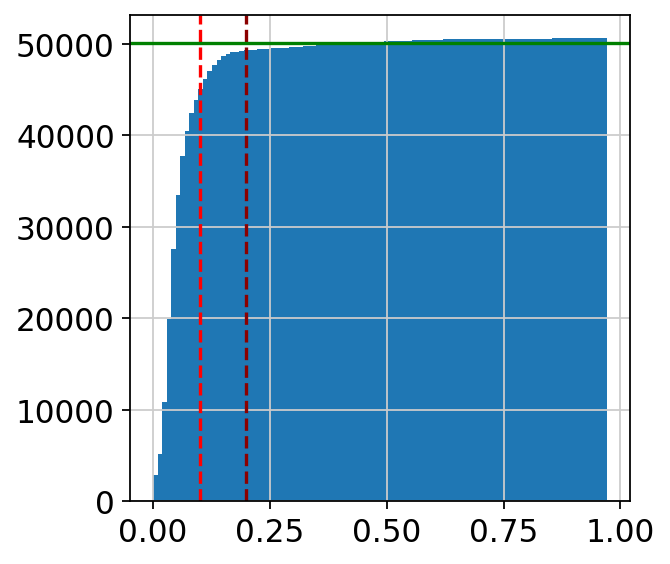

In [40]:
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(0.2, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [41]:
# <20%
adata = adata[adata.obs['percent_mito'] < 0.2, :]

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [42]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['sample'].values.describe()

Total number of cells: 49261
Total number of genes: 15799


,counts,freqs
categories,,
GSM4643732,8113,0.164694
GSM4643733,4645,0.094294
GSM4643734,10759,0.218408
GSM4643735,10411,0.211344
GSM4643736,3536,0.071781
GSM4643737,5807,0.117882
GSM4643738,5990,0.121597


In [43]:
adata.var.head()

,gene_ids-0,feature_types-0,n_cells-0,mouse_ENSEMBL-0,human_ENSEMBL-0,human_gene_ortholog-0,mouse_gene_name-0,gene_ids-1,feature_types-1,n_cells-1,...,human_gene_ortholog-5,mouse_gene_name-5,gene_ids-6,feature_types-6,n_cells-6,mouse_ENSEMBL-6,human_ENSEMBL-6,human_gene_ortholog-6,mouse_gene_name-6,n_cells
MT-ND1,ENSMUSG00000064341,Gene Expression,8176.0,ENSMUSG00000064341,ENSG00000198888,MT-ND1,mt-Nd1,ENSMUSG00000064341,Gene Expression,4480.0,...,MT-ND1,mt-Nd1,ENSMUSG00000064341,Gene Expression,5968.0,ENSMUSG00000064341,ENSG00000198888,MT-ND1,mt-Nd1,48591
MT-ND2,ENSMUSG00000064345,Gene Expression,8014.0,ENSMUSG00000064345,ENSG00000198763,MT-ND2,mt-Nd2,ENSMUSG00000064345,Gene Expression,4318.0,...,MT-ND2,mt-Nd2,ENSMUSG00000064345,Gene Expression,5546.0,ENSMUSG00000064345,ENSG00000198763,MT-ND2,mt-Nd2,47040
MT-CO1,ENSMUSG00000064351,Gene Expression,8149.0,ENSMUSG00000064351,ENSG00000198804,MT-CO1,mt-Co1,ENSMUSG00000064351,Gene Expression,4623.0,...,MT-CO1,mt-Co1,ENSMUSG00000064351,Gene Expression,6115.0,ENSMUSG00000064351,ENSG00000198804,MT-CO1,mt-Co1,49931
MT-CO2,ENSMUSG00000064354,Gene Expression,8142.0,ENSMUSG00000064354,ENSG00000198712,MT-CO2,mt-Co2,ENSMUSG00000064354,Gene Expression,4520.0,...,MT-CO2,mt-Co2,ENSMUSG00000064354,Gene Expression,6058.0,ENSMUSG00000064354,ENSG00000198712,MT-CO2,mt-Co2,49187
MT-ATP8,ENSMUSG00000064356,Gene Expression,3729.0,ENSMUSG00000064356,ENSG00000228253,MT-ATP8,mt-Atp8,ENSMUSG00000064356,Gene Expression,1516.0,...,MT-ATP8,mt-Atp8,ENSMUSG00000064356,Gene Expression,1944.0,ENSMUSG00000064356,ENSG00000228253,MT-ATP8,mt-Atp8,24909


### Save raw counts

In [44]:
# Not log transformed
adata.raw = adata.copy()

### Normalize per cell and log transform

After removing unwanted cells and genes from the dataset, the next step is to normalize the data. 
By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 

In [45]:
# Per cell normalization 
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# Filter HVGs
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, min_disp=0.25)
highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]
# Scale
sc.pp.scale(adata, max_value=10)
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

normalizing by total count per cell


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:11): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Total number of cells: 49261
Total number of genes: 3175


In [46]:
# Regress out cell cycle genes
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes, random_state = 123)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['S_score', 'G2M_score']


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1154: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'phase' as categorical


    finished (0:04:38)


    on highly variable genes


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


computing PCA with n_comps = 50
    finished (0:00:06)


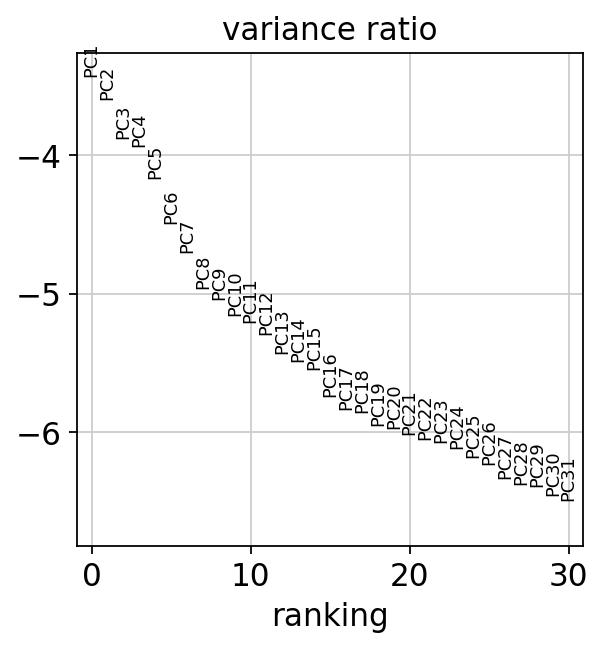

In [47]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

#### Visualize data

**UMAP**

In [48]:
n_pcs = 26

In [49]:
# Visualize
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 26
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:50)


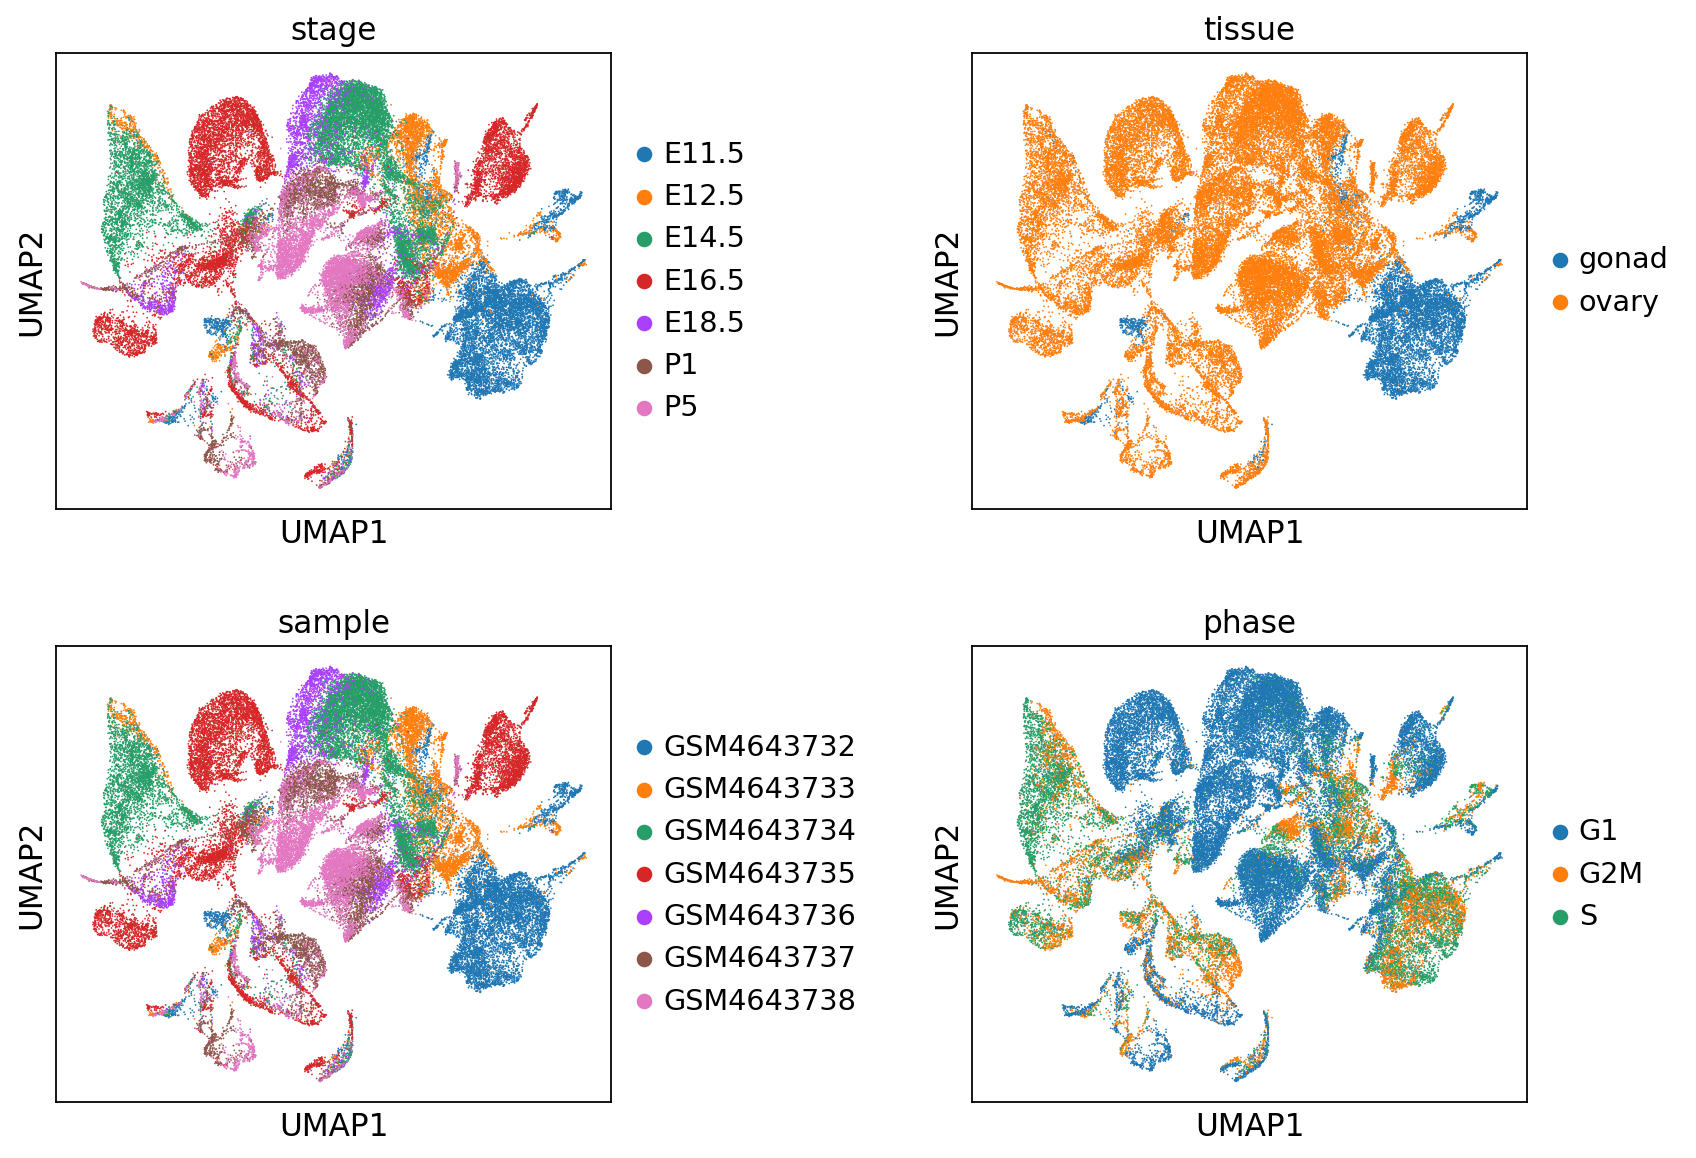

In [50]:
sc.pl.umap(adata, color = ['stage', 'tissue', 'sample', 'phase'], ncols = 2, wspace = 0.5, hspace = 0.3)

#### Save

In [51]:
adata.write('/nfs/team292/vl6/Mouse_Niu2020/preprocessing_beforeDoublets.h5ad')